In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast
import warnings
warnings.filterwarnings("ignore")


# Topics des articles ECB

On s'intéresse a la répartition des sujets par articles

In [76]:
df = pd.read_csv("df_topic_title.csv", index_col="date", parse_dates=True)
df["topic"] = df["topic"].apply(ast.literal_eval)

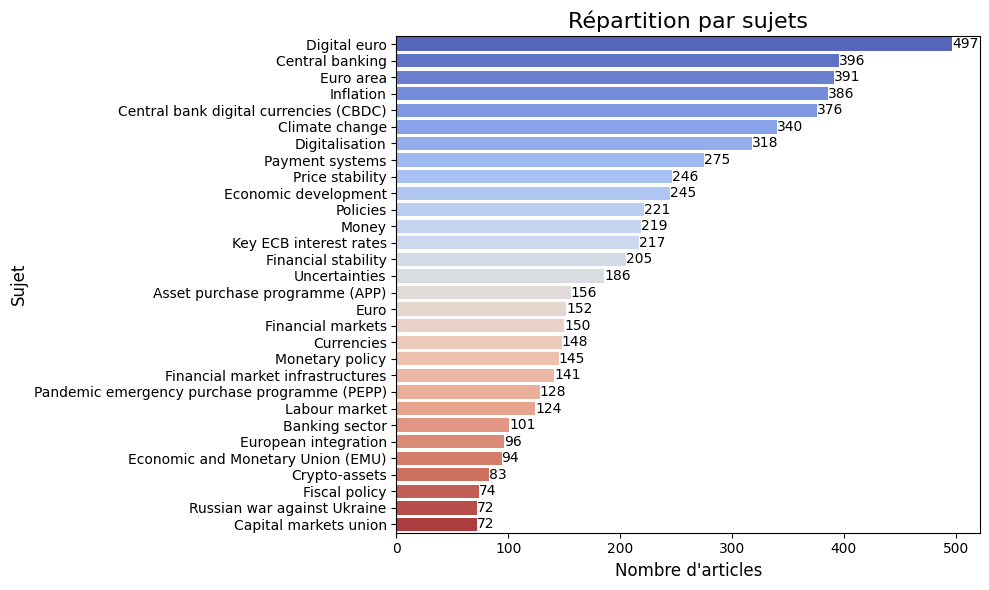

In [77]:
df_exploded = df.explode("topic")

topic_counts = df_exploded["topic"].value_counts().reset_index()
topic_counts.columns = ["topic", "count"]

top_topics = topic_counts.head(30)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_topics,
    x="count",
    y="topic",
    palette="coolwarm",
    legend=False,
)
plt.title("Répartition par sujets", fontsize=16)
plt.xlabel("Nombre d'articles", fontsize=12)
plt.ylabel("Sujet", fontsize=12)

for index, value in enumerate(top_topics["count"]):
    plt.text(value, index, str(value), va="center", ha="left", fontsize=10)

plt.tight_layout()
plt.show()

On a beaucoup de sujets et d'articles, mais un article peut avoir plusieurs sujets. Afin de grouper les sujets entre eux, on peut appliquer un algorithme de clustering (Kmeans) pour grouper les sujets "proches" entre eux en considérant la matrice de confusion (pour chaque pair de sujets, combien d'articles traite les 2 sujets simultanément)

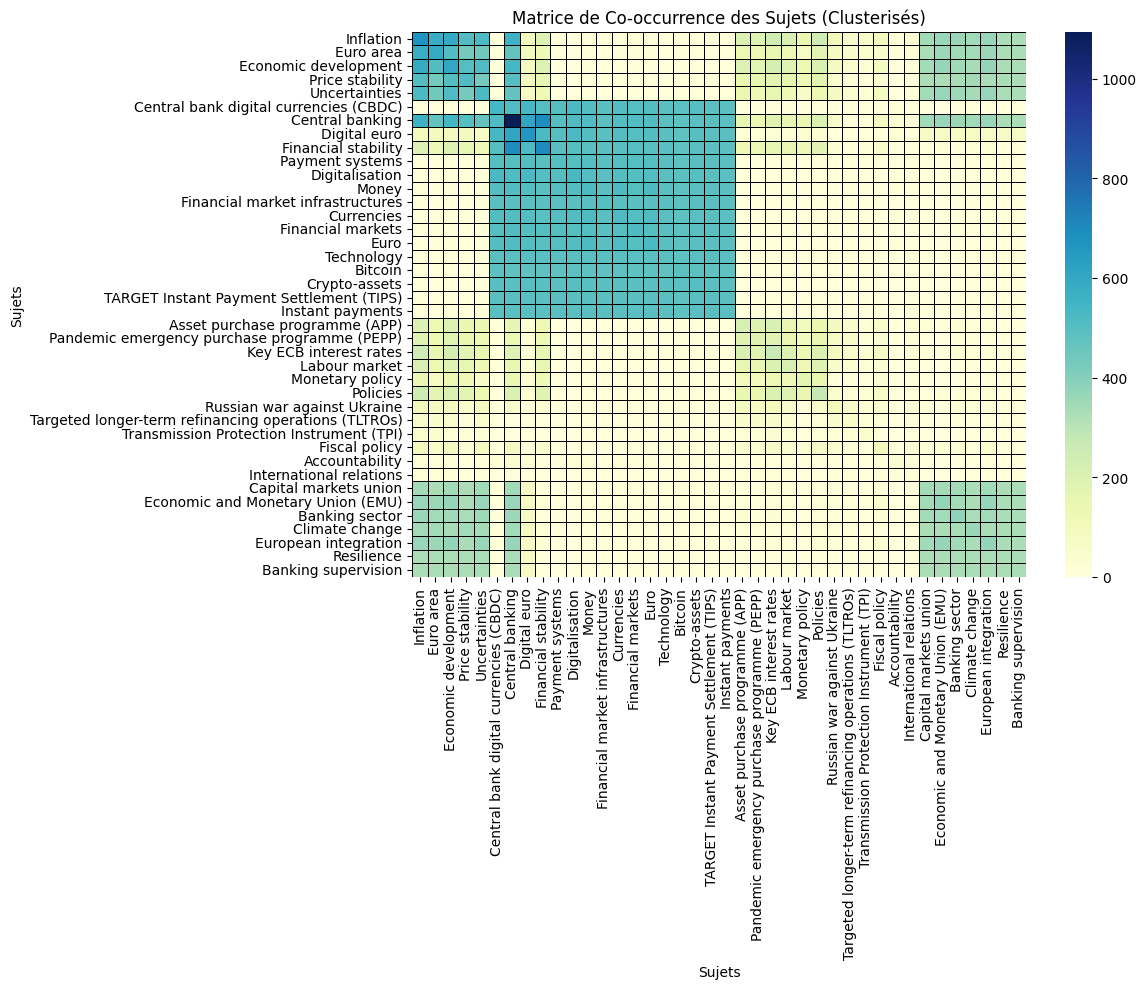

In [89]:
all_topics = df['topic'].explode()

topic_counts = all_topics.value_counts()

top_topics = topic_counts.head(40).index.tolist()

binary_matrix = pd.DataFrame(0, index=df.index, columns=top_topics)

for idx, row in df.iterrows():
    for topic in row['topic']:
        if topic in top_topics:
            binary_matrix.at[idx, topic] = 1

co_occurrence_matrix = binary_matrix.T.dot(binary_matrix)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(co_occurrence_matrix)

clusters = pd.DataFrame({
    'topic': co_occurrence_matrix.columns,
    'cluster': kmeans.labels_
})

sorted_topics = clusters.sort_values('cluster')['topic'].tolist()

co_occurrence_matrix_sorted = co_occurrence_matrix.loc[sorted_topics, sorted_topics]

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix_sorted, cmap='YlGnBu', annot=False, fmt='d', linewidths=0.5, linecolor='black')

plt.title("Matrice de Co-occurrence des Sujets (Clusterisés)")
plt.xlabel("Sujets")
plt.ylabel("Sujets")
plt.tight_layout()
plt.show()


In [90]:
for cluster in clusters["cluster"].unique():
    print("*"*20, f"\nCluster {cluster}:")
    print(clusters[clusters["cluster"]==cluster]["topic"].to_list())

******************** 
Cluster 1:
['Digital euro', 'Central banking', 'Central bank digital currencies (CBDC)', 'Digitalisation', 'Payment systems', 'Money', 'Financial stability', 'Euro', 'Financial markets', 'Currencies', 'Financial market infrastructures', 'Crypto-assets', 'Bitcoin', 'Technology', 'TARGET Instant Payment Settlement (TIPS)', 'Instant payments']
******************** 
Cluster 0:
['Euro area', 'Inflation', 'Price stability', 'Economic development', 'Uncertainties']
******************** 
Cluster 4:
['Climate change', 'Banking sector', 'European integration', 'Economic and Monetary Union (EMU)', 'Capital markets union', 'Banking supervision', 'Resilience']
******************** 
Cluster 2:
['Policies', 'Key ECB interest rates', 'Asset purchase programme (APP)', 'Monetary policy', 'Pandemic emergency purchase programme (PEPP)', 'Labour market']
******************** 
Cluster 3:
['Fiscal policy', 'Russian war against Ukraine', 'Targeted longer-term refinancing operations (TLTR